In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy.sparse as sp
import cupyx.scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
from scipy.constants import pi, speed_of_light, elementary_charge, electron_mass, hbar

me_SI = electron_mass
hbar_SI = hbar   
e_SI = elementary_charge
c_SI = speed_of_light

meV = e_SI * 1e-3
nm = 1e-9                    
ps = 1e-12                    

c = c_SI * ps / nm           
hbar_meV_ps = hbar_SI / (meV * ps)  
me = me_SI * c_SI**2 / meV / c**2    

hbar = hbar_meV_ps
m = me
omega = 2 / hbar
vQD = 15

x_min = -75
x_max = 150
t_min = 0
t_max = 50

x0 = 0
x1 = 75
t0 = 0
t1 = 2

In [3]:
Nx = 10000
Nt = 10000

x_values = cp.linspace(x_min, x_max, Nx)
t_values = cp.linspace(t_min, t_max, Nt)

dx = x_values[1] - x_values[0]
dt = t_values[1] - t_values[0]

In [4]:
laplacian = (cp.eye(Nx, k=-1) - 2 * cp.eye(Nx) + cp.eye(Nx, k=1)) / dx ** 2
H_kinetic = - (hbar ** 2 / (2 * m)) * laplacian

In [5]:
A = (m * omega / (cp.pi * hbar)) ** 0.25
alpha = (m * omega) / (2.0 * hbar)

psi = A * cp.exp(-alpha * (x_values ** 2))
# psi /= np.sqrt(np.sum(psi ** 2) * dx)

In [6]:
def quantum_center(t_values):
    xqd_arr = cp.zeros_like(t_values)
    
    for i, t in enumerate(t_values):
        if t < t1:
            xqd_arr[i] = x0
        elif t < t1 + (x1 - x0) / vQD:
            xqd_arr[i] = x0 + vQD * (t - t1)
        else:
            xqd_arr[i] = x1

    return xqd_arr

In [7]:
psi_real_analytical = cp.zeros((Nx, Nt), dtype=cp.float64)
psi_img_analytical = cp.zeros((Nx, Nt), dtype=cp.float64)

psi_real_analytical[:, 0] = cp.real(psi)
psi_img_analytical[:, 0] = cp.imag(psi)

I = cp.eye(Nx)
xqd_arr = quantum_center(t_values)

for t_i in range(1, Nt):
    if t_i % 100 == 0:
        print(f"Step {t_i} / {Nt}")
    V = 0.5 * m * omega ** 2 * (x_values - xqd_arr[t_i]) ** 2
    H = H_kinetic + cp.diag(V)
    A = I + 1j * dt / (2 * hbar) * H
    B = I - 1j * dt / (2 * hbar) * H
    psi = spla.spsolve(sp.csc_matrix(A), B @ psi)
    # psi /= np.sqrt(np.sum(psi ** 2) * dx)
    psi_real_analytical[:, t_i] = cp.real(psi)
    psi_img_analytical[:, t_i] = cp.imag(psi)

/usr/local/lib/python3.10/dist-packages/cupyx/scipy/sparse/linalg/_solve.py:508: SparseEfficiencyWarning: CSR format is required. Converting to CSR format.
  warnings.warn('CSR format is required. Converting to CSR format.',


Step 100 / 10000
Step 200 / 10000
Step 300 / 10000
Step 400 / 10000
Step 500 / 10000
Step 600 / 10000
Step 700 / 10000
Step 800 / 10000
Step 900 / 10000
Step 1000 / 10000
Step 1100 / 10000
Step 1200 / 10000
Step 1300 / 10000
Step 1400 / 10000
Step 1500 / 10000
Step 1600 / 10000
Step 1700 / 10000
Step 1800 / 10000
Step 1900 / 10000
Step 2000 / 10000
Step 2100 / 10000
Step 2200 / 10000
Step 2300 / 10000
Step 2400 / 10000
Step 2500 / 10000
Step 2600 / 10000
Step 2700 / 10000
Step 2800 / 10000
Step 2900 / 10000
Step 3000 / 10000
Step 3100 / 10000
Step 3200 / 10000
Step 3300 / 10000
Step 3400 / 10000
Step 3500 / 10000
Step 3600 / 10000
Step 3700 / 10000
Step 3800 / 10000
Step 3900 / 10000
Step 4000 / 10000
Step 4100 / 10000
Step 4200 / 10000
Step 4300 / 10000
Step 4400 / 10000
Step 4500 / 10000
Step 4600 / 10000
Step 4700 / 10000
Step 4800 / 10000
Step 4900 / 10000
Step 5000 / 10000
Step 5100 / 10000
Step 5200 / 10000
Step 5300 / 10000
Step 5400 / 10000
Step 5500 / 10000
Step 5600 / 10000
S

In [8]:
psi_real_analytical = cp.asnumpy(psi_real_analytical)
psi_img_analytical = cp.asnumpy(psi_img_analytical)
x_values = cp.asnumpy(x_values)
t_values = cp.asnumpy(t_values)

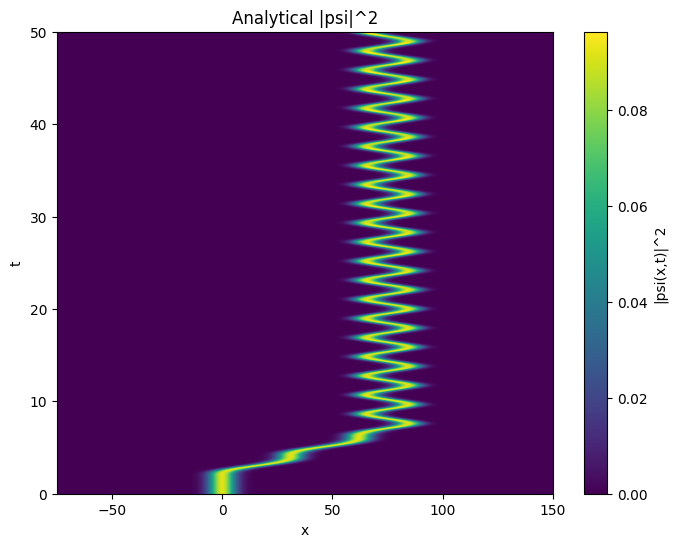

In [9]:
plt.figure(figsize=(8, 6))
psi_sq = psi_real_analytical ** 2 + psi_img_analytical ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Analytical |psi|^2')
plt.show()

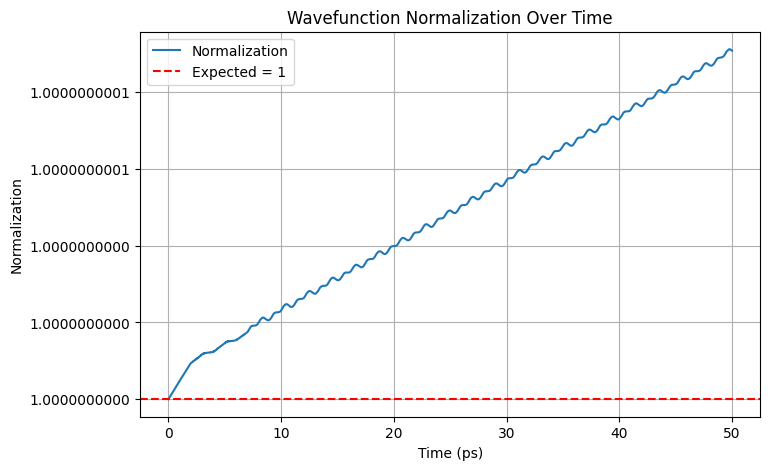

In [10]:
from scipy.integrate import simpson
from matplotlib.ticker import FormatStrFormatter

norms = []

for i in range(10000):
  psi_sq = psi_real_analytical[:, i] ** 2 + psi_img_analytical[:, i] ** 2
  normalization = simpson(psi_sq, x=x_values)
  norms.append(normalization)

plt.figure(figsize=(8,5))
plt.plot(t_values, norms, '-', label='Normalization')
plt.axhline(1.0, color='red', linestyle='--', label='Expected = 1')
plt.xlabel('Time (ps)')
plt.ylabel('Normalization')
plt.title('Wavefunction Normalization Over Time')
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.10f'))

plt.show()

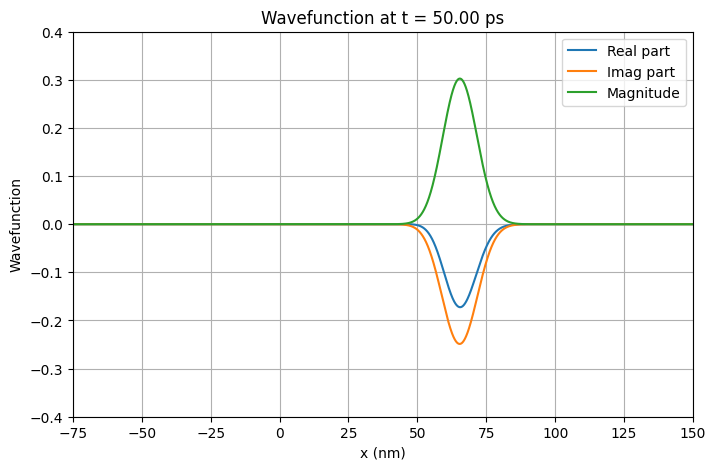

In [11]:
def update(frame):
    time_chosen = t_values[frame]
    psi_real_slice_analytical = psi_real_analytical[:, frame]
    psi_img_slice_analytical = psi_img_analytical[:, frame]

    psi_mag_slice_analytical = np.sqrt(psi_real_slice_analytical**2 + psi_img_slice_analytical**2)

    line_real.set_data(x_values, psi_real_slice_analytical)
    line_img.set_data(x_values, psi_img_slice_analytical)
    line_mag.set_data(x_values, psi_mag_slice_analytical)

    ax.set_title(f"Wavefunction at t = {time_chosen:.2f} ps")
    return line_real, line_img, line_mag

fig, ax = plt.subplots(figsize=(8,5))
line_real, = ax.plot([], [], label='Real part')
line_img, = ax.plot([], [], label='Imag part')
line_mag, = ax.plot([], [], label='Magnitude')
ax.set_xlim(x_min, x_max)
ax.set_ylim(-0.4, 0.4)
ax.set_xlabel('x (nm)')
ax.set_ylabel('Wavefunction')
ax.set_title('Wavefunction Evolution')
ax.legend()
ax.grid(True)

anim = animation.FuncAnimation(fig, update, frames=Nt, interval=50, blit=True)
from IPython.display import HTML
HTML(anim.to_html5_video())